### Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import time

#### Load DATA

In [2]:
def fetch_ohlcv_all(exchange, symbol, timeframe='1d', since=None, limit=1000, sleep=1):
    """
    Récupère l'historique OHLCV complet (daily) pour un symbole donné,
    en paginant les appels car la plupart des exchanges limitent à 1000 barres par requête.

    Arguments :
        exchange (ccxt.Exchange) : instance CCXT de l'exchange (ex: ccxt.binance())
        symbol (str)            : paire à récupérer, ex: 'BTC/USDT'
        timeframe (str)         : timeframe souhaité ('1d' pour daily)
        since (int|None)        : timestamp (en ms) du début (None → valeur par défaut)
        limit (int)             : nombre max de bougies par appel (1000 sur Binance)
        sleep (float)           : délai (en secondes) entre chaque appel pour respecter le rate-limit

    Retourne :
        pandas.DataFrame indexé par la date/heure, avec colonnes ['open','high','low','close','volume'].
    """
    all_ohlcv = []
    if since is None:
        since = exchange.parse8601('2017-01-01T00:00:00Z')

    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        all_ohlcv += ohlcv
        last_ts = ohlcv[-1][0]
        since = last_ts + 1
        if len(ohlcv) < limit:
            break
        time.sleep(sleep)

    df = pd.DataFrame(all_ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('datetime')
    df = df[['open','high','low','close','volume']]
    return df

if __name__ == "__main__":
    exchange = ccxt.binance({
        'enableRateLimit': True,
        'options': {
            'defaultType': 'spot'
        }
    })

    exchange.load_markets()
    symbols = ['BTC/USDT']

    for symbol in symbols:
        print(f"--- Récupération historique {symbol} en 1d ---")
        df_daily = fetch_ohlcv_all(exchange, symbol, timeframe='1d', since=None, limit=1000, sleep=1)

        # Sauvegarde en CSV
        filename = f"{symbol.replace('/','')}_daily.csv"
        df_daily.to_csv(filename, index=True, float_format="%.6f")
        print(f"→ {len(df_daily)} bougies daily récupérées pour {symbol}. Sauvegardé dans {filename}.\n")

        print(df_daily.tail())

--- Récupération historique BTC/USDT en 1d ---
→ 2967 bougies daily récupérées pour BTC/USDT. Sauvegardé dans BTCUSDT_daily.csv.

                 open       high        low      close       volume
datetime                                                           
2025-09-26  108994.49  110300.00  108620.07  109643.46  14243.01591
2025-09-27  109643.46  109743.91  109064.40  109635.85   5501.78643
2025-09-28  109635.85  112350.00  109189.99  112163.95   7542.33160
2025-09-29  112163.96  114400.00  111560.65  114311.96  15541.12005
2025-09-30  114311.97  114792.00  112656.27  112832.33   7364.61864


In [3]:
df_btc_d = pd.read_csv('BTCUSDT_daily.csv', index_col=0, parse_dates=True)
df_avax_d = pd.read_csv('AVAXUSDT_daily.csv', index_col=0, parse_dates=True)

df_avax_d

,open,high,low,close,volume
datetime,,,,,
2020-09-22,0.8500,7.0000,0.8500,5.3193,31441883.16
2020-09-23,5.3279,5.3600,3.4000,3.5350,12620608.01
2020-09-24,3.5305,4.8873,3.4033,4.6411,7107843.86
2020-09-25,4.6366,5.0234,4.2001,4.7134,3886096.71
2020-09-26,4.7164,4.8200,4.3294,4.5200,1814932.97
...,...,...,...,...,...
2025-09-24,33.6000,34.8500,32.2600,32.3100,4766219.20
2025-09-25,32.3100,32.8000,28.5100,28.6400,7152756.29
2025-09-26,28.6300,29.6000,27.0700,29.0900,6421766.72


#### Backtesting

In [6]:
def compute_metrics(returns, freq):
    ann_return = (np.prod(1 + returns))**(freq / len(returns)) - 1
    ann_vol = np.std(returns, ddof=1) * np.sqrt(freq)
    sharpe_ratio = ann_return / ann_vol if ann_vol != 0 else np.nan
    cumulative = (1 + returns).cumprod()
    max_dd = (cumulative / cumulative.cummax()).min() - 1
    return ann_return, ann_vol, sharpe_ratio, max_dd

 Meilleure fenêtre (sharpe) : 6d
 Max Drawdown : -48.95%
 Sharpe Ratio : 1.91
 Performance finale nette : 82.16


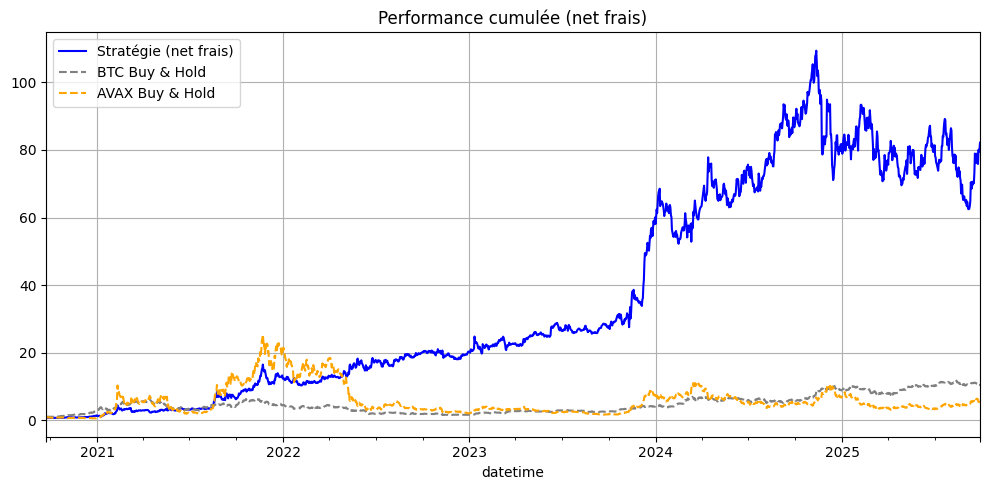

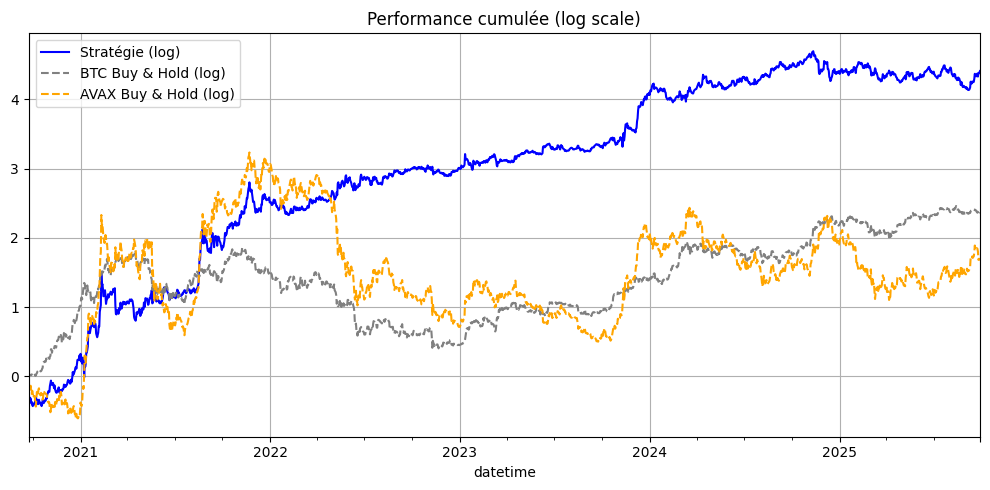

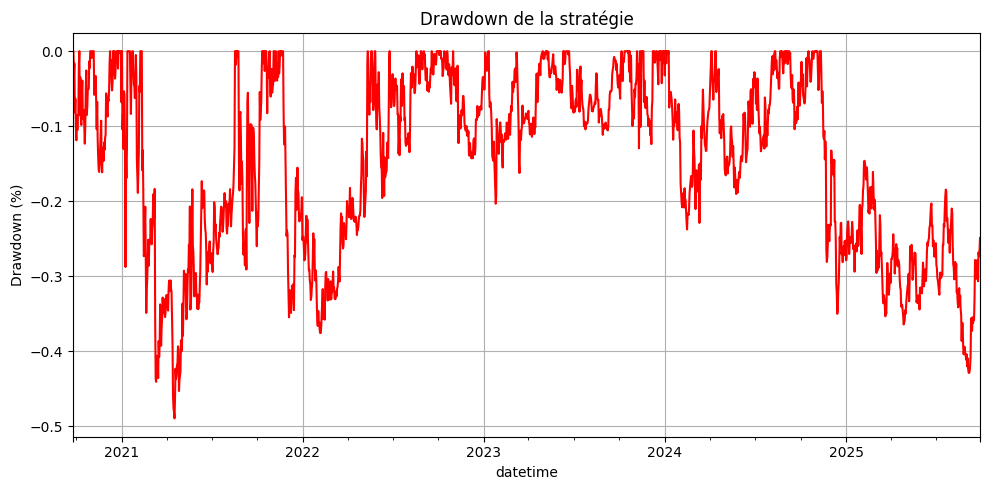

In [12]:
frais = 0.0006  # 0.06% market order Bitget
optimiser_par = 'sharpe'  # ou 'drawdown'
freq = 365 # daily

df_agg = df_btc_d['close'].to_frame(name='BTC').join(
    df_avax_d['close'].to_frame(name='AVAX'),
    how='inner'
)
df_agg['relatif'] = df_agg['BTC'] / df_agg['AVAX']
df_agg['relatif return'] = df_agg['relatif'].pct_change() 
df_agg['BTC return'] = df_agg['BTC'].pct_change()
df_agg['AVAX return'] = df_agg['AVAX'].pct_change()
df_agg = df_agg.dropna()

# Fenêtres à tester
windows = range(1, 30, 1)
results = []

for window in windows:
    df = df_agg.copy()
    #df['ma_rel'] = df['relatif'].rolling(window).mean()
    df['ma_rel'] = df['relatif'].ewm(span=window, adjust=False).mean()
    df['poids btc'] = np.where(df['relatif'] > df['ma_rel'], 0.75, -0.75)
    df['poids avax'] = np.where(df['relatif'] < df['ma_rel'],0.75 ,-0.75)
    df['poids btc'] = df['poids btc'].shift(1)
    df['poids avax'] = df['poids avax'].shift(1)
    df = df.dropna()

    # Rendement brut
    df['strategy return'] = (
        df['poids btc'] * df['BTC return'] +
        df['poids avax'] * df['AVAX return']
    )

    # === AOUT DES FRAIS ===
    # Un chngement de signal = ouverture/fermeture de positions BTC + ETH
    # => frais = 2 * frais (BTC + ETH)
    changements = (df['poids btc'].shift(1) != df['poids btc']).astype(int)
    df['frais'] = changements * 2 * frais

    # Rendement net de frais
    df['strategy return net'] = df['strategy return'] - df['frais']

    ann_return, ann_vol, sharpe, max_dd = compute_metrics(df['strategy return net'], freq)
    cumulative = 1 * (1 + df['strategy return net']).cumprod()

    results.append({
        'window': window,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'perf_finale': cumulative.iloc[-1],
        'perf_cum': cumulative,
        'returns': df['strategy return net']
    })

if optimiser_par == 'sharpe':
    best = max(results, key=lambda x: x['sharpe'])
elif optimiser_par == 'drawdown':
    best = max(results, key=lambda x: x['max_drawdown'])
else:
    raise ValueError("optimiser_par doit être 'sharpe' ou 'drawdown'")

print(f" Meilleure fenêtre ({optimiser_par}) : {best['window']}d")
print(f" Max Drawdown : {best['max_drawdown']:.2%}")
print(f" Sharpe Ratio : {best['sharpe']:.2f}")
print(f" Performance finale nette : {best['perf_finale']:.2f}")

# --- GRAPH PERFORMANCE CUMULÉE ---
plt.figure(figsize=(10, 5))
best['perf_cum'].plot(label=f"Stratégie (net frais)", color='blue')
(df_agg['BTC return'] + 1).cumprod().plot(label='BTC Buy & Hold', linestyle='--', color='grey')
(df_agg['AVAX return'] + 1).cumprod().plot(label='AVAX Buy & Hold', linestyle='--', color='orange')
plt.title("Performance cumulée (net frais)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- GRAPH EN LOG ---
plt.figure(figsize=(10, 5))
np.log(best['perf_cum']).plot(label=f"Stratégie (log)", color='blue')
np.log((df_agg['BTC return'] + 1).cumprod()).plot(label='BTC Buy & Hold (log)', linestyle='--', color='grey')
np.log((df_agg['AVAX return'] + 1).cumprod()).plot(label='AVAX Buy & Hold (log)', linestyle='--', color='orange')
plt.title("Performance cumulée (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- GRAPH DRAWDOWN ---
cumulative = best['perf_cum']
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max

plt.figure(figsize=(10, 5))
drawdown.plot(color='red')
plt.title("Drawdown de la stratégie")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.tight_layout()
plt.show()
